In [2]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.datasource import YahooDataSource
from src.prediction import PredictionModeling
from src.bayesianopt import bayesianOpt
from src.riskmeasure import CumulativeReturn, ExponationalUtility
from src.utils import buy_signal_plots, calculate_drawdown
from src.utils import find_cointegrated_pairs,get_top_k_pairs,get_cointergrated_coeff
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Data Extraction

In [3]:
# Extract the Data from the Yahoo Data Source
start_date = datetime.datetime(2019, 3, 29)
end_date = datetime.datetime(2024, 3, 29)
tickers  =  ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
columns =   ["High","Close","Low","Volume"]
ds = YahooDataSource(start_date,end_date,tickers,columns)

In [4]:
# Get only Close column data
df_pair_search = ds.get_data_by_column_tickers(columns=["Close"],tickers=-1)

In [5]:
df_pair_search.head(n=5)
scores, pvalues, pairs = find_cointegrated_pairs(df_pair_search)

top_pairs = get_top_k_pairs(pairs,5)
print("Top pairs",top_pairs)

# Get first pair
tickers = ds.get_tickers(top_pairs[0][0])
print("Top ticker",tickers)

Top pairs [(('AMD_Close', 'MSFT_Close'), 0.018010489058989314)]
Top ticker ['AMD', 'MSFT']


In [6]:
first_series = 'MSFT_Close'
second_series =  'AMD_Close'

In [7]:
# Gather High, Low ,Close , Volume of selected stocks
columns = ["High","Close","Low","Volume"]
df_raw = ds.get_data_by_column_tickers(columns=columns,tickers=tickers)

In [8]:
df_raw

,AMD_Low,AMD_Close,AMD_High,AMD_Volume,MSFT_Low,MSFT_Close,MSFT_High,MSFT_Volume
0,25.250000,25.520000,25.730000,53502800,110.489791,111.415581,111.774557,25399800
1,25.830000,26.360001,26.559999,63000300,111.566718,112.435822,112.520846,22789100
2,26.090000,26.750000,26.799999,53358800,111.963487,112.596428,112.870386,18142300
3,27.879999,29.020000,29.950001,197650500,112.558630,113.333267,113.767819,22860700
4,28.610001,29.090000,29.389999,82191100,111.831222,112.757011,113.578886,20112800
...,...,...,...,...,...,...,...,...
1254,175.050003,179.649994,180.759995,57832100,422.841763,425.491516,426.603025,17636500
1255,172.000000,178.630005,182.800003,71935300,418.415538,419.656067,424.171611,18060500
1256,176.330002,177.869995,182.600006,65322400,418.157485,418.455200,422.762313,16725600
1257,175.399994,179.589996,181.229996,55685600,415.835230,418.236877,421.234015,16705000


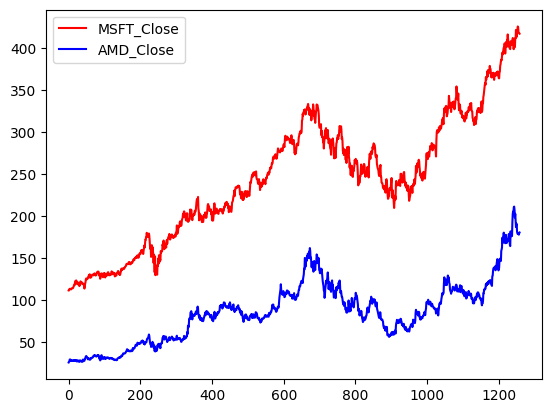

In [9]:
plt.plot(df_raw[first_series],color='r')
plt.plot(df_raw[second_series],color='b')
plt.legend([f'{first_series}',f'{second_series}'])

In [10]:
# Find ratio between co-integrated pairs
coeff = get_cointergrated_coeff(df_raw[first_series],df_raw[second_series])
print(coeff)

-1.939737679412768


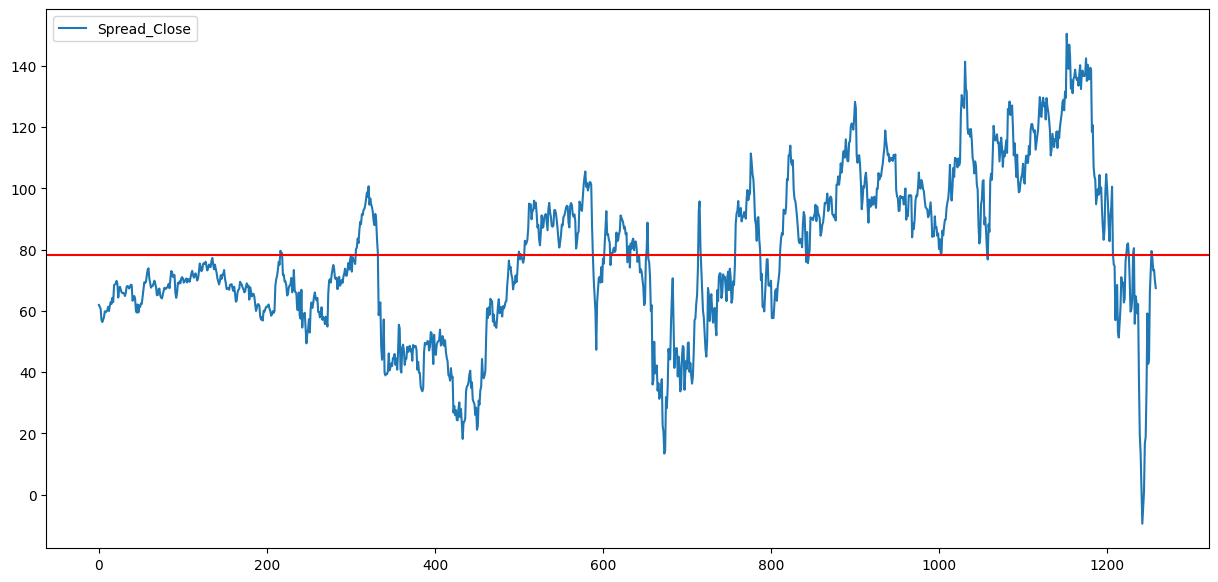

In [11]:
df_raw['Spread_Close'] = df_raw[first_series] + (df_raw[second_series] * coeff)
df_raw['Spread_Close'].plot(figsize=(15,7))
plt.axhline(df_raw['Spread_Close'].mean(),c='red')
plt.legend(['Spread_Close'])

In [12]:
pm = PredictionModeling(df_raw,"Spread_Close",0.60,1)

In [13]:
pm.add_arima_forecast("Spread_Close",order=(1,1,0))

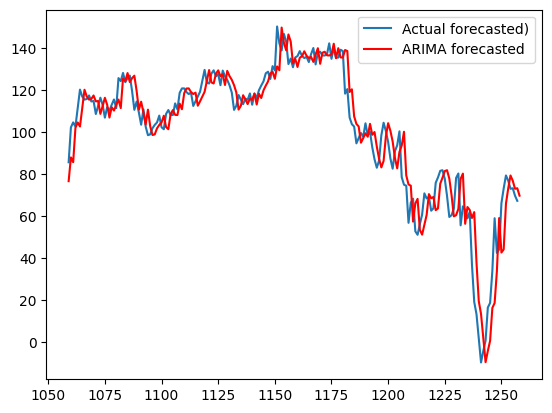

In [14]:
plt.plot(pm.data["Spread_Close_Actual_value_fore_perod_1"][-200:])
plt.plot(pm.data["Spread_Close_ARIMA_forecast_1"][-200:],color='r')
plt.legend(["Actual forecasted)","ARIMA forecasted"])

In [15]:
pm.data

,AMD_Low,AMD_Close,AMD_High,AMD_Volume,MSFT_Low,MSFT_Close,MSFT_High,MSFT_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1
0,25.250000,25.520000,25.730000,53502800,110.489791,111.415581,111.774557,25399800,61.913474,[61.30433511996063],61.304335,61.304335,NaN,NaN
1,25.830000,26.360001,26.559999,63000300,111.566718,112.435822,112.520846,22789100,61.304335,[60.70844499318892],60.708445,60.708445,NaN,NaN
2,26.090000,26.750000,26.799999,53358800,111.963487,112.596428,112.870386,18142300,60.708445,[57.04207886741409],57.042079,57.042079,NaN,NaN
3,27.879999,29.020000,29.950001,197650500,112.558630,113.333267,113.767819,22860700,57.042079,[56.33004202347632],56.330042,56.330042,NaN,NaN
4,28.610001,29.090000,29.389999,82191100,111.831222,112.757011,113.578886,20112800,56.330042,[57.04407048006333],57.044070,57.044070,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,175.050003,179.649994,180.759995,57832100,422.841763,425.491516,426.603025,17636500,77.017654,[73.1607157496531],73.160716,73.160716,79.506383,[79.50638342697738]
1255,172.000000,178.630005,182.800003,71935300,418.415538,419.656067,424.171611,18060500,73.160716,[73.43406862953884],73.434069,73.434069,77.026238,[77.02623775613786]
1256,176.330002,177.869995,182.600006,65322400,418.157485,418.455200,422.762313,16725600,73.434069,[69.87939469919877],69.879395,69.879395,73.172726,[73.1727257856043]
1257,175.399994,179.589996,181.229996,55685600,415.835230,418.236877,421.234015,16705000,69.879395,[67.42902318514842],67.429023,67.429023,73.433209,[73.43320862160998]


In [16]:
pm.data[:907]

,AMD_Low,AMD_Close,AMD_High,AMD_Volume,MSFT_Low,MSFT_Close,MSFT_High,MSFT_Volume,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1
0,25.250000,25.520000,25.730000,53502800,110.489791,111.415581,111.774557,25399800,61.913474,[61.30433511996063],61.304335,61.304335,NaN,NaN
1,25.830000,26.360001,26.559999,63000300,111.566718,112.435822,112.520846,22789100,61.304335,[60.70844499318892],60.708445,60.708445,NaN,NaN
2,26.090000,26.750000,26.799999,53358800,111.963487,112.596428,112.870386,18142300,60.708445,[57.04207886741409],57.042079,57.042079,NaN,NaN
3,27.879999,29.020000,29.950001,197650500,112.558630,113.333267,113.767819,22860700,57.042079,[56.33004202347632],56.330042,56.330042,NaN,NaN
4,28.610001,29.090000,29.389999,82191100,111.831222,112.757011,113.578886,20112800,56.330042,[57.04407048006333],57.044070,57.044070,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,59.150002,59.730000,61.770000,79761600,225.257656,226.491364,233.325657,82543200,110.630833,[108.34815961418535],108.348160,108.348160,126.215158,[126.21515841843441]
903,58.509998,58.599998,62.720001,83871400,221.067031,222.016785,228.811920,40424600,108.348160,[110.66323511184486],110.663235,110.663235,110.779473,[110.77947296354715]
904,58.919998,62.009998,62.349998,78198600,221.331359,230.946365,231.661138,40647700,110.663235,[110.78382191513701],110.783822,110.783822,108.365035,[108.36503509836605]
905,59.529999,60.060001,61.860001,73274100,226.324916,227.284470,230.016224,28357300,110.783822,[107.6823700931913],107.682370,107.682370,110.645427,[110.64542723407621]


# Data Prepareation of Hyperparameter Tuning for Trading Strategy

In [17]:
total_length =(len(pm.data) - pm.train_end_index)-1
train_size = 0.70
length_param_training = int((len(pm.data) - pm.train_end_index)*0.70)

In [18]:
test_data = pm.data[[first_series,second_series,"Spread_Close","Spread_Close_Actual_value_fore_perod_1","Spread_Close_ARIMA_forecast_1"]][pm.train_end_index:-1]

In [19]:

spread_ARIMA_val = test_data["Spread_Close_ARIMA_forecast_1"][:length_param_training]
S1_val = test_data[first_series][:length_param_training]
S2_val = test_data[second_series][:length_param_training]

spread_ARIMA_test = test_data["Spread_Close_ARIMA_forecast_1"][length_param_training:]

S1_test = test_data[first_series][length_param_training:]
S2_test = test_data[second_series][length_param_training:]

In [19]:
45*4000*6

1080000

# Define set of Hyper parameters

In [104]:
sell_treshold_params = np.linspace(0.4,3,20)
buy_threshold_params = np.linspace(-0.4,-3,20)
clear_threshold_params = np.linspace(0,0.3,10)
window1_param = np.arange(15,100,2)
window2_param = np.arange(1,14,1)
window_param = list(zip(window1_param,window2_param))

param_grid = { 'window1':window1_param,
              'window2':window2_param,
              "sell_threshold":sell_treshold_params,
              "buy_threshold":buy_threshold_params,
              "clear_threshold":clear_threshold_params }
config_dict = {"num_iteration":150}

In [105]:
buy_threshold_params


array([-0.4       , -0.53684211, -0.67368421, -0.81052632, -0.94736842,
       -1.08421053, -1.22105263, -1.35789474, -1.49473684, -1.63157895,
       -1.76842105, -1.90526316, -2.04210526, -2.17894737, -2.31578947,
       -2.45263158, -2.58947368, -2.72631579, -2.86315789, -3.        ])

# Trading Strategy using Trading Strategy using ARIMA

In [144]:

cumilative_return = CumulativeReturn()
byopt =  bayesianOpt(cumilative_return)
params = byopt.optimize(coeff,spread_ARIMA_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]



Best score: 60566.46361540986: 100%|██████████| 150/150 [03:20<00:00,  1.34s/it]

{'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.5368421052631579, 'window1': 57, 'window2': 7}


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, 447.91471430702427, -6.318022793050204, -465.79516907285097, -924.0313072533985, -1378.3024642214052, -1845.6477555434149, -1845.6477555434149, -1845.6477555434149, -1845.6477555434149, -1845.6477555434149, -1337.5973017090216, -839.082815449302, -344.97150395164635, 143.13715029392313, 627.2804310128809, 1114.2456537228368, 1601.6936833771715, 2099.943823544925, 2593.9349535155616, 3086.6081067220425, 3569.551513051343, 4058.864078168478, 4557.389245489767, 5064.187677754642, 5566.842543954012, 6070.165926930978, 6070.165926930978, 6070.165926930978, 6070.165926930978, 6578.0572203196

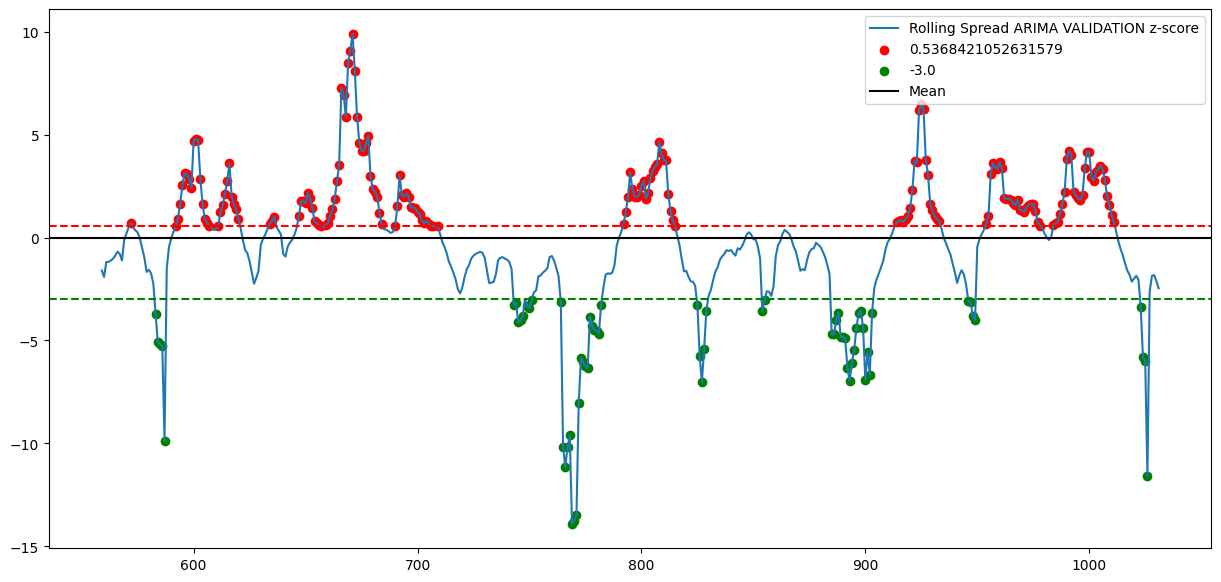

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -540.7588815432662, -8.372376762838712, 516.9603452004911, 1053.836422658172, 1587.339882175979, 2112.0029529964368, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2627.851947835228, 2105.856794063753, 1594.1151239775074, 1091.8043965834274, 591.81034135681, 89.0034082601183, -405.71072197732303

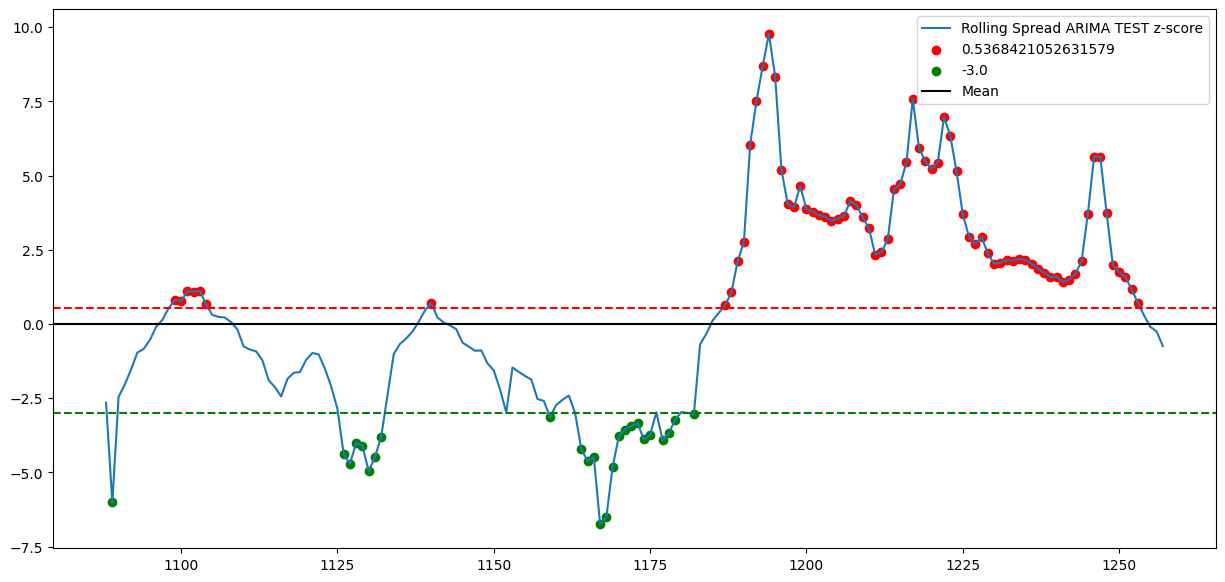

Optimal Parameters {'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.5368421052631579, 'window1': 57, 'window2': 7}
Money on validation data 60566.46361540986
Money on test data 37801.59161820525


In [158]:
money_val = byopt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
print(money_val)
buy_signal_plots(spread_ARIMA_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="ARIMA VALIDATION")

money_test = byopt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
print(money_test)
buy_signal_plots(spread_ARIMA_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="ARIMA TEST")


print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val[-1])
print("Money on test data",money_test[-1])

In [173]:
exponational_risk = ExponationalUtility(0.006)
byopt_exp =  bayesianOpt(exponational_risk)
params_exp = byopt_exp.optimize(coeff,spread_ARIMA_val,S1_val,S2_val,param_grid,config_dict)
print(byopt_exp.optimize_results["best_params"])
window1_exp = byopt_exp.optimize_results["best_params"]["window1"]
window2_exp = byopt_exp.optimize_results["best_params"]["window2"]
sell_threshold_exp = byopt_exp.optimize_results["best_params"]["sell_threshold"]
buy_threshold_exp = byopt_exp.optimize_results["best_params"]["buy_threshold"]
clear_threshold_exp = byopt_exp.optimize_results["best_params"]["clear_threshold"]


Best score: -0.05983578725303714: 100%|██████████| 150/150 [03:50<00:00,  1.54s/it]

{'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.6736842105263159, 'window1': 23, 'window2': 12}


In [174]:
rd_window_1 = 65
rd_window_2 = 10
rd_sell_threshold = 1
rd_buy_threshold = -2
rd_clear_threshold = 0

# Optimal Parameters {'buy_threshold': -3.0, 'clear_threshold': 0.0, 'sell_threshold': 0.5368421052631579, 'window1': 65, 'window2': 12}
# Money on validation data 75911.82971778436
# Money on test data 38066.41664118262

In [175]:
money_val_rd = bayesianOpt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,rd_window_1,rd_window_2,rd_sell_threshold,rd_buy_threshold,rd_clear_threshold)
money_val_opt = bayesianOpt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
money_val_exp_opt = bayesianOpt.trade(S1_val,S2_val,spread_ARIMA_val,coeff,window1_exp, window2_exp,sell_threshold_exp,buy_threshold_exp,clear_threshold_exp)

In [176]:
# Calculate Exponational Utility

def utility(risk_aversion,money_arr):
    return -1*np.mean(np.exp(-risk_aversion *np.array(money_arr)))

print("Risk Aversion Utility rd",utility(0.009,money_val_rd))
print("Risk Aversion Utility opt",utility(0.009,money_val_opt))
print("Risk Aversion Utility exp",utility(0.009,money_val_exp_opt))


Risk Aversion Utility rd -17104367.69282556
Risk Aversion Utility opt -155792.59732642534
Risk Aversion Utility exp -0.05838289857981539


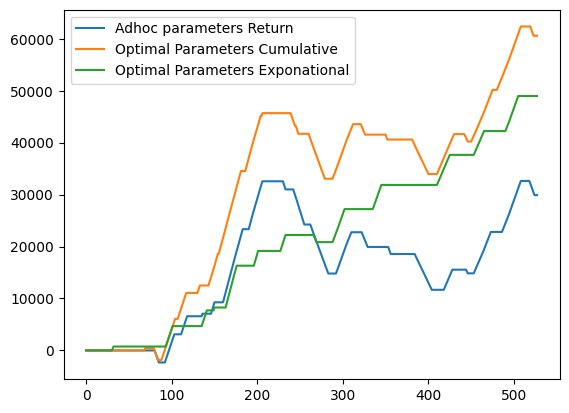

In [177]:
plt.plot(money_val_rd)
plt.plot(money_val_opt)
plt.plot(money_val_exp_opt)
plt.legend(["Adhoc parameters Return","Optimal Parameters Cumulative","Optimal Parameters Exponational"])

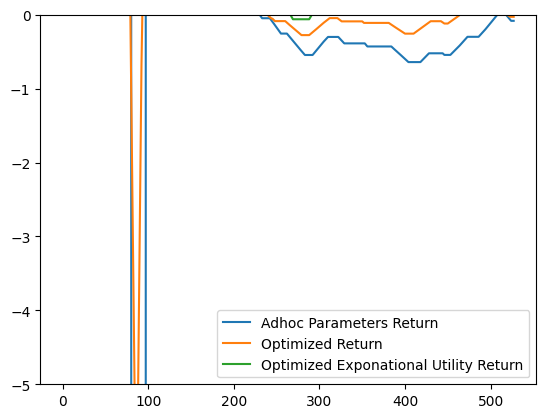

In [178]:
plt.plot(calculate_drawdown(money_val_rd),label="Adhoc Parameters Return")
plt.plot(calculate_drawdown(money_val_opt),label="Optimized Return")
plt.plot(calculate_drawdown(money_val_exp_opt),label="Optimized Exponational Utility Return")
plt.ylim([-5,0])
plt.legend()


In [179]:
val_drawdown = np.min(calculate_drawdown(money_val_rd))
val_opt_drawdown = np.min(calculate_drawdown(money_val_opt))
val_exp_drawdown = np.min(calculate_drawdown(money_val_exp_opt))

print("Val drawdown",val_drawdown)
print("Val optimized drawdown",val_opt_drawdown)
print("Val optimized exponational drawdown",val_exp_drawdown)


Val drawdown -2316.0
Val optimized drawdown -5.12751677852349
Val optimized exponational drawdown -0.061917832875849343


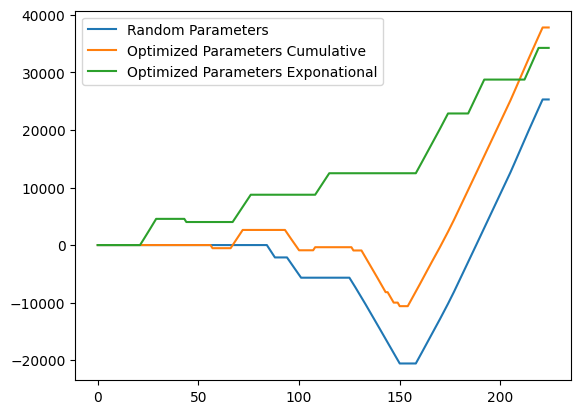

In [180]:
money_test_rd = bayesianOpt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,rd_window_1,rd_window_2,rd_sell_threshold,rd_buy_threshold,rd_clear_threshold)
money_test_opt = bayesianOpt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,window1, window2,sell_threshold,buy_threshold,clear_threshold)
money_test_exp_opt = bayesianOpt.trade(S1_test,S2_test,spread_ARIMA_test,coeff,window1_exp, window2_exp,sell_threshold_exp,buy_threshold_exp,clear_threshold_exp)
plt.plot(money_test_rd)
plt.plot(money_test_opt)
plt.plot(money_test_exp_opt)
plt.legend(["Random Parameters","Optimized Parameters Cumulative","Optimized Parameters Exponational"])

In [181]:
print("Money gain using random parameters",money_test_rd[-1])
print("Money gain using optimized parameters",money_test_opt[-1])
print("Money gain using optimized parameters exponational",money_test_exp_opt[-1])

print("Performance gain over benchmark Cumilative  ",(money_test_opt[-1]- money_test_rd[-1])/money_test_rd[-1])

print("Performance gain over benchmark exponational",(money_test_exp_opt[-1]- money_test_rd[-1])/money_test_rd[-1])


Money gain using random parameters 25296.318585215406
Money gain using optimized parameters 37801.59161820525
Money gain using optimized parameters exponational 34254.480760370556
Performance gain over benchmark Cumilative   0.4943514998383454
Performance gain over benchmark exponational 0.3541290858184718


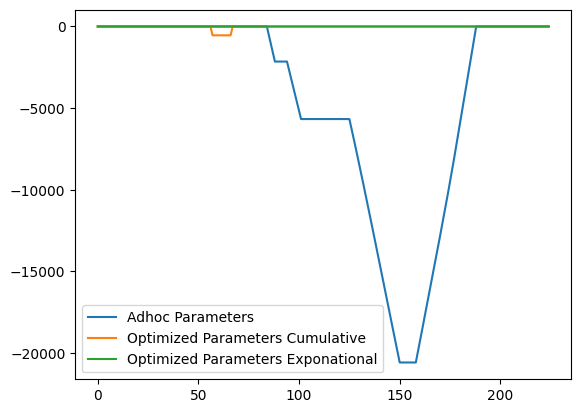

In [182]:
plt.plot(calculate_drawdown(money_test_rd),label="Adhoc Parameters")
plt.plot(calculate_drawdown(money_test_opt),label="Optimized Parameters Cumulative")
plt.plot(calculate_drawdown(money_test_exp_opt),label="Optimized Parameters Exponational")
# plt.ylim(-1,0)
plt.legend()

In [183]:
val_test_rd = calculate_drawdown(money_test_rd)
val_test_opt = calculate_drawdown(money_test_opt)
val_test_exp_op = calculate_drawdown(money_test_exp_opt)

print("Test drawdown",np.min(val_test_rd))
print("Test optimized drawdown",np.min(val_test_opt))
print("Test optimized drawdown",np.min(val_test_exp_op))

#Reduction in drawdown
print("Reduction in drawdown Cumilative  ",(np.min(val_test_rd)-np.min(val_test_opt))/np.min(val_test_rd))
print("Reduction in drawdown Exponational  ",(np.min(val_test_rd)-np.min(val_test_exp_op))/np.min(val_test_rd))





Test drawdown -20571.0
Test optimized drawdown -541.0
Test optimized drawdown -0.12038664323374342
Reduction in drawdown Cumilative   0.9737008409897429
Reduction in drawdown Exponational   0.9999941477495876


In [49]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
result = adfuller(pm.data['Spread_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.663120
p-value: 0.004663


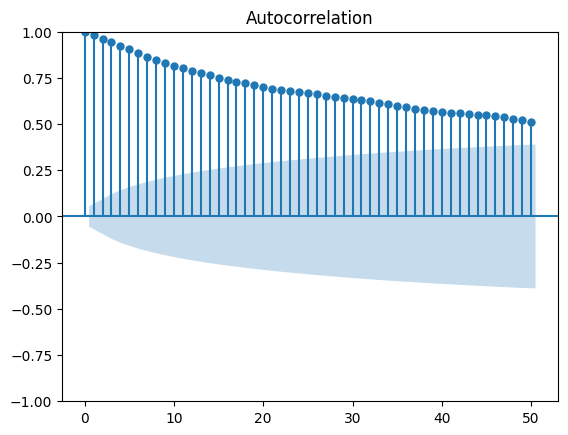

In [ ]:
plot_acf(pm.data['Spread_Close'],lags=50)
plt.show()

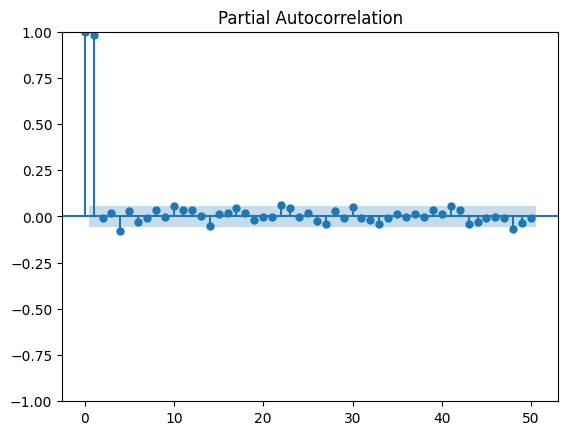

In [135]:
plot_pacf(pm.data['Spread_Close'],lags=50)
plt.show()

In [136]:
result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.470556
p-value: 0.000000


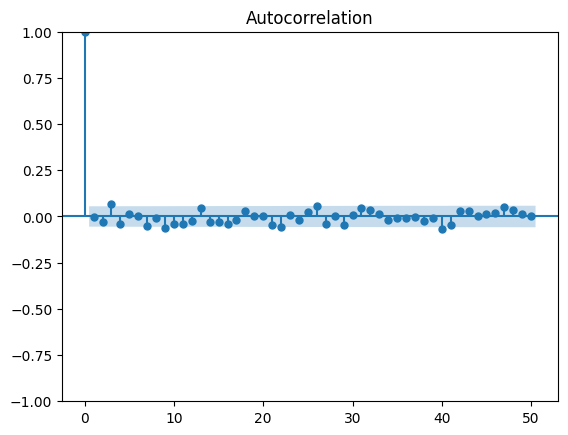

In [137]:
plot_acf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

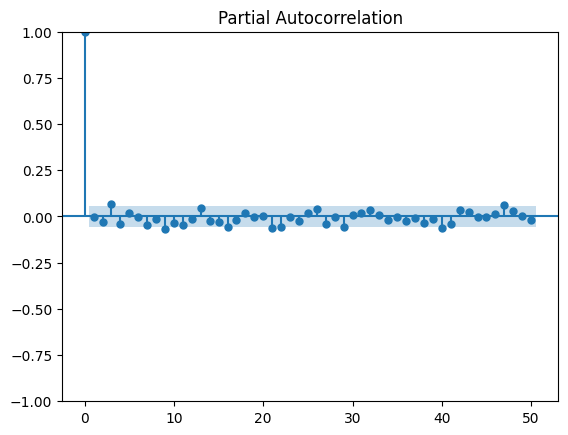

In [138]:
plot_pacf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

In [139]:

result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.470556
p-value: 0.000000
